In [74]:
import pandas as pd
import matplotlib
import numpy as np

# Modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

from tensorflow.keras.utils import plot_model


# visualização e gráficos
import plotly.express as px
import matplotlib.pyplot as plt
from itertools import cycle
import scikitplot as skplt
import seaborn as sns


# Avaliação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix

In [5]:
df_train = pd.read_csv("dataset_tratado/train_df.csv")
df_val = pd.read_csv("dataset_tratado/validation_df.csv")
df_test = pd.read_csv("dataset_tratado/test_df.csv")

In [77]:
X_train = df_train.drop('satisfied', axis=1)
y_train = df_train['satisfied'].astype(int)

X_val = df_val.drop('satisfied', axis=1)
y_val = df_val['satisfied'].astype(int)

X_test = df_test.drop('satisfied', axis=1)
y_test = df_test['satisfied'].astype(int)

In [22]:
# Função para criar o modelo MLP
def create_mlp(input_dim, output_dim, hidden_layers=2, 
               neurons_per_layer=64, activation='relu', dropout_rate=0.0, l2_reg=0.0):
    model = Sequential()
    model.add(Dense(neurons_per_layer, input_dim=input_dim, 
                    activation=activation, kernel_regularizer=l2(l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    for i in range(hidden_layers):
        model.add(Dense(int(neurons_per_layer/(2**i)), activation=activation, 
                        kernel_regularizer=l2(l2_reg)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(output_dim, activation='softmax'))
    return model

In [23]:
# Função para escolher o otimizador
def get_optimizer(optimizer_name, learning_rate):
    if optimizer_name == 'adadelta':
        return Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        return SGD(learning_rate=learning_rate)
    else:
        raise ValueError("O nome do otimizador não é válido.")

In [85]:
#Hyperarametros
input_dim = X_train.shape[1] # Dimensão do vetor de entrada == Número de features
output_dim = 1
hidden_layers = 1
neurons_per_layer = 128
activation = 'relu'
dropout_rate = 0.5
l2_reg = 0.01
learning_rate = 0.001
optimizer_name = 'adam'
epochs = 10000
patience = 3

In [42]:
# Criando o modelo
mlp_model = create_mlp(input_dim, output_dim, hidden_layers, neurons_per_layer, activation, dropout_rate, l2_reg)

d:\LUCAS\UFPE\8o_PERIODO\Redes Neurais\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Escolhendo o otimizador
optimizer = get_optimizer(optimizer_name, learning_rate)

In [65]:
# Compilando o modelo
mlp_model.compile(optimizer='adam',
                  loss='mean_squared_error',  # Exemplo de função de perda para classificação
                  metrics=[CategoricalAccuracy(), Precision(), Recall()])

In [66]:
mlp_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 128)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,993 (82.00 KB)

 Trainable params: 20,993 (82.00 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Callback para early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [92]:
X_val.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Class_Eco,Class_Eco Plus,Departure Delay Category_10 minutos até 30 minutos,Departure Delay Category_30 min até 1 hora,Departure Delay Category_Mais de 1 hora,Departure Delay Category_Menos de 10 minutos,Arrival Delay Category_10 minutos até 30 minutos,Arrival Delay Category_30 min até 1 hora,Arrival Delay Category_Mais de 1 hora,Arrival Delay Category_Menos de 10 minutos
0,0.141026,0.116115,0.6,0.8,0.6,0.2,0.8,0.6,0.8,0.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.153846,0.077342,0.4,0.8,0.4,0.2,1.0,0.4,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.730769,0.092892,0.4,1.0,0.4,0.8,1.0,0.2,0.6,0.8,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.320513,0.182956,0.6,0.2,0.2,0.2,0.6,0.6,0.6,0.6,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.410256,0.059370,0.6,0.8,0.8,0.8,0.6,0.6,0.6,0.6,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [86]:
# Treinando o modelo
import tensorflow.keras as keras
keras.config.disable_traceback_filtering()
history = mlp_model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

Epoch 1/10000
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 1.0000 - loss: 0.5660 - precision_3: 0.4340 - recall_3: 1.0000 - val_categorical_accuracy: 1.0000 - val_loss: 0.5691 - val_precision_3: 0.4309 - val_recall_3: 1.0000
Epoch 2/10000
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 1.0000 - loss: 0.5662 - precision_3: 0.4338 - recall_3: 1.0000 - val_categorical_accuracy: 1.0000 - val_loss: 0.5691 - val_precision_3: 0.4309 - val_recall_3: 1.0000
Epoch 3/10000
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 1.0000 - loss: 0.5666 - precision_3: 0.4334 - recall_3: 1.0000 - val_categorical_accuracy: 1.0000 - val_loss: 0.5691 - val_precision_3: 0.4309 - val_recall_3: 1.0000
Epoch 4/10000
2436/2436 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 1.0000 - loss: 0.5654 - precision_3: 0.4346 - recall_3: 1.0000 - val_categorical_accuracy: 1.0000 - val_loss: 0.5691 - val_precision_3: 0.4309 - val_recall_3: 1.0000
Epoch 5/1000

In [68]:
#Funções Auxilires
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

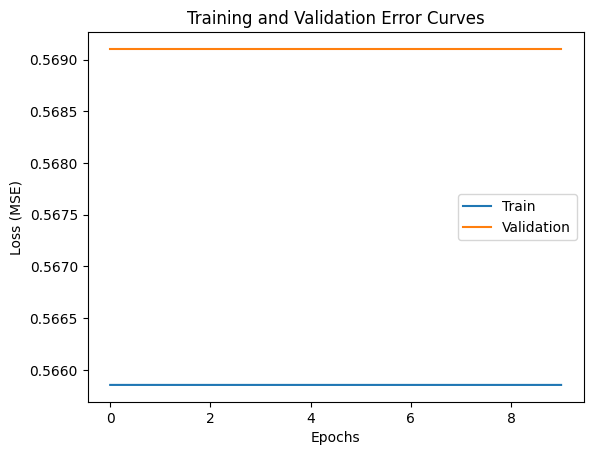

In [87]:
plot_training_error_curves(history)


In [88]:
# Fazer predições no conjunto de teste
y_pred_scores = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_scores, axis=1)
y_pred_class = (y_pred_scores >= 0.5).astype(int)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
conf_matrix = confusion_matrix(y_test, y_pred_class)



3247/3247 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Matriz de confusão no conjunto de teste:


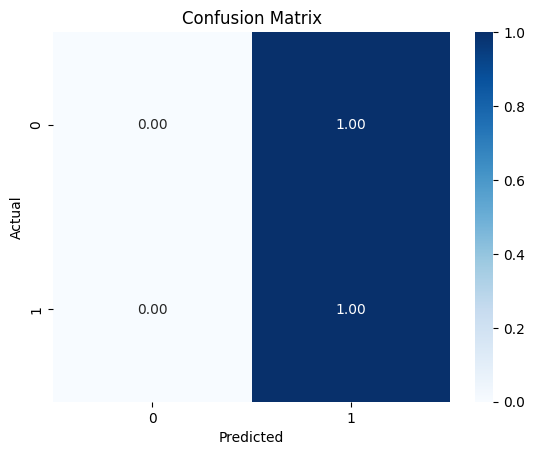

In [82]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show plot
plt.show()


Train Loss:       0.5659
Validation Loss:  0.5691

Performance no conjunto de teste:


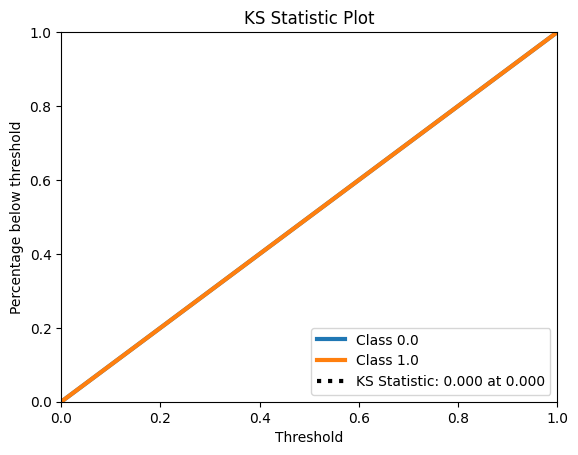


Accuracy:         0.4333
Recall:           1.0000
Precision:        0.4333
F1:               0.6047
AUROC:            0.5000
AUPR:             0.4333


In [76]:
## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Otimização de hyperparametros com hyperopt